In [33]:
import cv2
import numpy as np
from pathlib import Path
import tifffile
import os
import sys
import matplotlib.pyplot as plt

In [51]:
def list_tif_files(directory="."):
    """List all .tif files in current directory"""
    tif_files = []
    for file in os.listdir(directory):
        if file.endswith('.tif'):
            print(f"Found: {file}")
            tif_files.append(file)
    return tif_files

def count_cells(image_path):
    try:
        img = tifffile.imread(str(image_path))
    except Exception as e:
        raise ValueError(f"Error reading TIFF file: {str(e)}")
    
    # Convert to 8-bit if necessary
    if img.dtype != np.uint8:
        img_normalized = ((img - img.min()) * (255.0 / (img.max() - img.min()))).astype(np.uint8)
    else:
        img_normalized = img.copy()
        
    # Ensure image is BGR
    if len(img_normalized.shape) == 2:
        img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2BGR)
    
    # Convert to grayscale for total cell counting
    gray = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2GRAY)
    
    # Enhance contrast for better cell detection
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_enhanced = clahe.apply(gray)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray_enhanced, (5, 5), 0)
    
    # Use Otsu's thresholding instead of adaptive
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to clean up the mask
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Dilate slightly to connect cell components
    dilated = cv2.dilate(opening, kernel, iterations=1)
    
    # Find contours for all cells
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by size and circularity
    #min_cell_area = 50
    min_cell_area = 100  # Increased from 50
    max_cell_area = 2000
    valid_contours = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_cell_area < area < max_cell_area:
            # Calculate circularity
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
            
            # Accept if somewhat circular (adjust thresholds as needed)
            if 0.3 < circularity < 1.0:
                valid_contours.append(contour)
    
    total_cells = len(valid_contours)
    
    # Green cell detection (keep this part as is since it's working well)
    green_channel = img_normalized[:, :, 1]
    mean_intensity = np.mean(green_channel)
    std_intensity = np.std(green_channel)
    threshold_value = mean_intensity + 2.5 * std_intensity
    
    _, green_thresh = cv2.threshold(green_channel, threshold_value, 255, cv2.THRESH_BINARY)
    green_thresh = cv2.morphologyEx(green_thresh, cv2.MORPH_OPEN, kernel)
    
    green_contours, _ = cv2.findContours(green_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_green_contours = []
    for contour in green_contours:
        area = cv2.contourArea(contour)
        if 30 < area < 1000:
            mask = np.zeros(green_channel.shape, np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_intensity = cv2.mean(green_channel, mask=mask)[0]
            if mean_intensity > threshold_value:
                valid_green_contours.append(contour)
    
    green_cells = len(valid_green_contours)
    
    # Create visualization
    visualization = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    # Draw all cell contours in blue
    cv2.drawContours(visualization, valid_contours, -1, (255, 0, 0), 1)
    # Draw green cell contours in green
    cv2.drawContours(visualization, valid_green_contours, -1, (0, 255, 0), 2)
    
    # Save visualization
    output_path = os.path.join(os.path.dirname(image_path), 
                              f"{os.path.splitext(os.path.basename(image_path))[0]}_analyzed.jpg")
    cv2.imwrite(output_path, visualization)
    
    return total_cells, green_cells, output_path




def process_image_file(image_path):
    try:
        print(f"\nProcessing {Path(image_path).name}...")
        total_cells, green_cells, output_path = count_cells(image_path)
        print(f"Total cells detected: {total_cells}")
        print(f"Green fluorescent cells: {green_cells}")
        print(f"Analysis visualization saved to: {output_path}")
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

In [17]:
def list_tif_files(directory="."):
    """Recursively list all .tif files in directory and its subdirectories"""
    tif_files = []
    
    print(f"Searching for .tif files in: {os.path.abspath(directory)}")
    
    try:
        # Walk through directory tree
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.tif'):
                    full_path = os.path.join(root, file)
                    if os.path.isfile(full_path):
                        relative_path = os.path.relpath(root, directory)
                        print(f"Found: {file}")
                        print(f"In directory: {relative_path}")
                        print(f"Full path: {full_path}\n")
                        tif_files.append(full_path)
                    else:
                        print(f"Warning: {file} exists but is not accessible")
        
        if not tif_files:
            print("No .tif files found!")
        else:
            print(f"\nFound {len(tif_files)} .tif files in total")
            
    except Exception as e:
        print(f"Error accessing directory: {e}")
    
    return tif_files

# Test the file access
print(f"Current working directory: {os.getcwd()}")
print("\nSearching for .tif files recursively...")
tif_files = list_tif_files()
print(f"\nTotal .tif files found: {len(tif_files)}")

# Optionally, print a summary of directories where files were found
if tif_files:
    directories = set(os.path.dirname(file) for file in tif_files)
    print("\nFiles found in these directories:")
    for directory in directories:
        count = sum(1 for file in tif_files if os.path.dirname(file) == directory)
        print(f"{directory}: {count} files")

Current working directory: /Users/pranavdhinakar/Documents/Charles/Data

Searching for .tif files recursively...
Searching for .tif files in: /Users/pranavdhinakar/Documents/Charles/Data
Found: DFCP1 1ug 2.tif
In directory: trial 2/48h/DFCP1 1ug
Full path: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 2.tif

Found: DFCP1 1ug 3.tif
In directory: trial 2/48h/DFCP1 1ug
Full path: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 3.tif

Found: DFCP1 1ug 1.tif
In directory: trial 2/48h/DFCP1 1ug
Full path: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 1.tif

Found: atg13 0.5ug 1.tif
In directory: trial 2/48h/atg13 0.5
Full path: ./trial 2/48h/atg13 0.5/atg13 0.5ug 1.tif

Found: atg13 0.5ug 2.tif
In directory: trial 2/48h/atg13 0.5
Full path: ./trial 2/48h/atg13 0.5/atg13 0.5ug 2.tif

Found: atg13 0.5ug 3.tif
In directory: trial 2/48h/atg13 0.5
Full path: ./trial 2/48h/atg13 0.5/atg13 0.5ug 3.tif

Found: atg13 2ug 1.tif
In directory: trial 2/48h/atg13 2ug
Full path: ./trial 2/48h/atg13 2ug/atg13 2ug 1.tif

Found: atg13 2ug 2.tif
I

In [53]:
def process_files(file_paths, save_visualizations=True):
    """
    Process multiple image files and generate reports
    
    Parameters:
    file_paths : list of str
        List of file paths to process
    save_visualizations : bool
        Whether to save visualization images
    """
    results = []
    
    for file_path in file_paths:
        try:
            print(f"\nProcessing: {os.path.basename(file_path)}")
            print(f"From directory: {os.path.dirname(file_path)}")
            
            # Process the image and get results
            total_cells, green_cells, output_path = count_cells(file_path)
            
            # Store results
            result = {
                'filename': os.path.basename(file_path),
                'directory': os.path.dirname(file_path),
                'total_cells': total_cells,
                'green_cells': green_cells,
                'green_percentage': round((green_cells / total_cells * 100), 2) if total_cells > 0 else 0,
                'visualization_path': output_path if save_visualizations else None
            }
            results.append(result)
            
            # Print individual file results
            print("\nResults:")
            print(f"Total cells: {total_cells}")
            print(f"Green cells: {green_cells}")
            print(f"Green percentage: {result['green_percentage']}%")
            if save_visualizations:
                print(f"Visualization saved to: {output_path}")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    return results

# Example usage for a single file:
# Choose the first file from our list for testing
if tif_files:
    test_file = tif_files[15]
    print(f"\nTesting with single file: {test_file}")
    results = process_files([test_file])
    
    # You can access the results as a list of dictionaries
    if results:
        print("\nProcessing complete! Results available in 'results' variable")
else:
    print("No files available to process!")

"""
# Example for multiple files (commented out for now):
# Process specific files by index
selected_indices = [0, 1, 2]  # Process first three files
selected_files = [tif_files[i] for i in selected_indices]
results = process_files(selected_files)

# Or process files by pattern
selected_files = [f for f in tif_files if "DFCP1" in f]
results = process_files(selected_files)
"""


Testing with single file: ./trial 2/48h/DFCP1 0.5ug/DFCP1 0.5ug 3.tif

Processing: DFCP1 0.5ug 3.tif
From directory: ./trial 2/48h/DFCP1 0.5ug

Results:
Total cells: 310
Green cells: 28
Green percentage: 9.03%
Visualization saved to: ./trial 2/48h/DFCP1 0.5ug/DFCP1 0.5ug 3_analyzed.jpg

Processing complete! Results available in 'results' variable


'\n# Example for multiple files (commented out for now):\n# Process specific files by index\nselected_indices = [0, 1, 2]  # Process first three files\nselected_files = [tif_files[i] for i in selected_indices]\nresults = process_files(selected_files)\n\n# Or process files by pattern\nselected_files = [f for f in tif_files if "DFCP1" in f]\nresults = process_files(selected_files)\n'

./trial 2/48h/DFCP1 0.5ug/DFCP1 0.5ug 3.tif


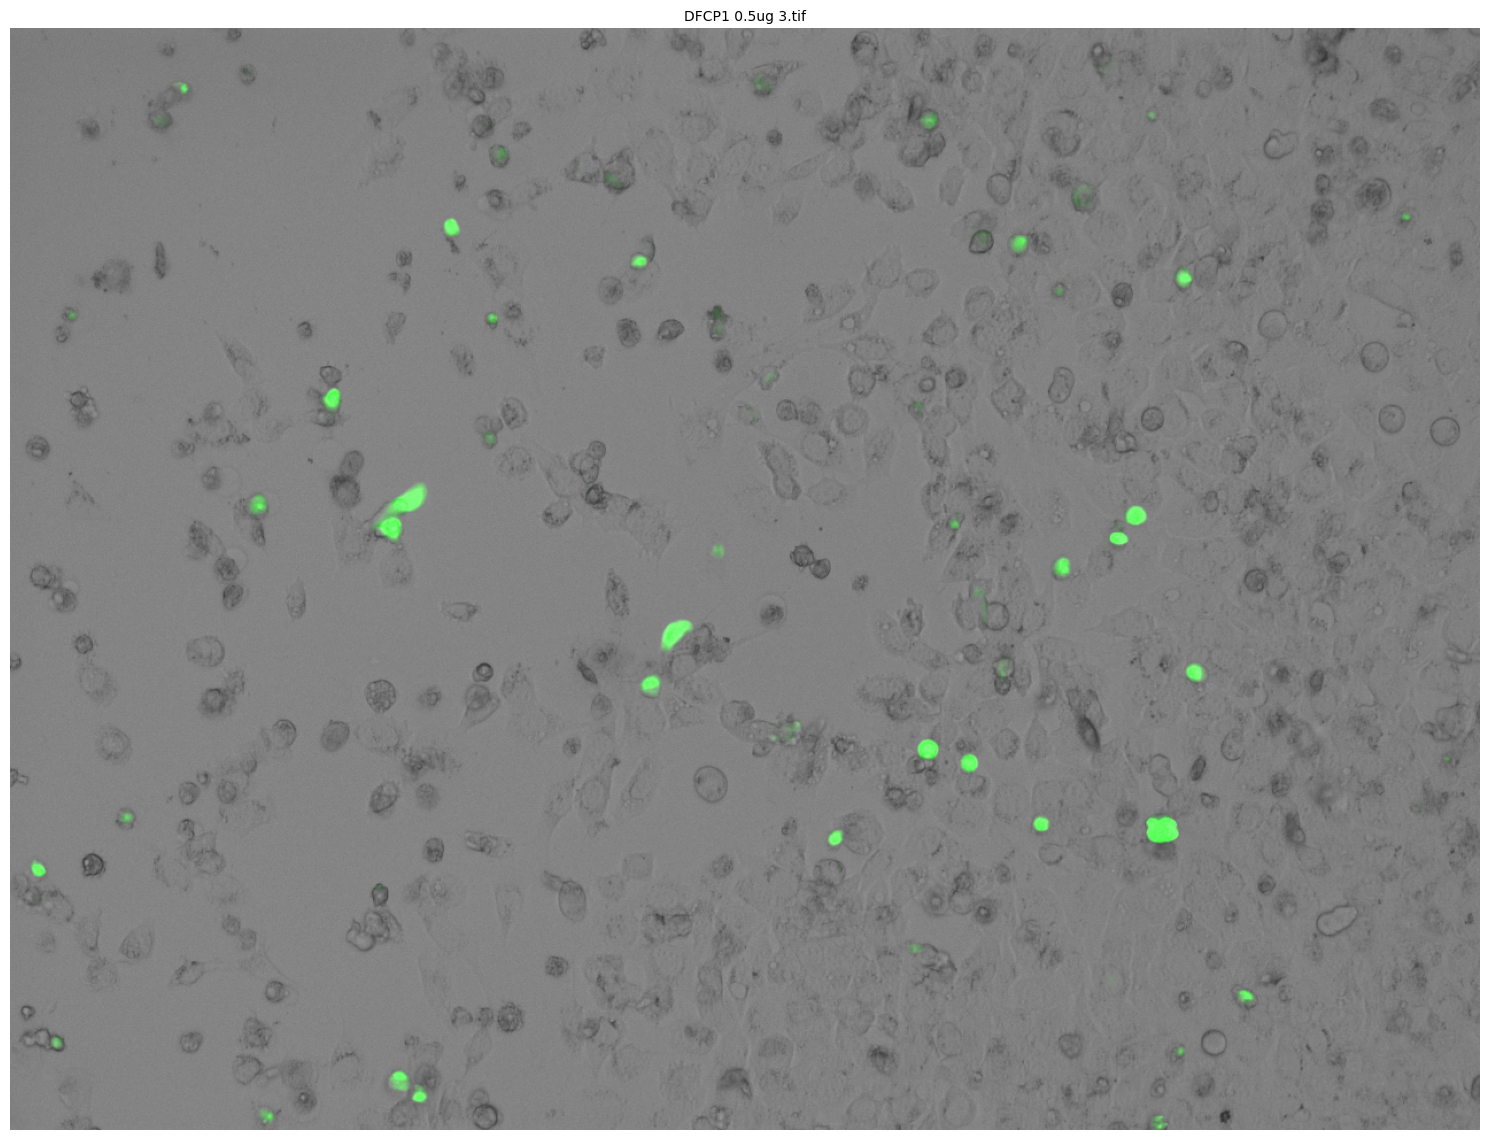

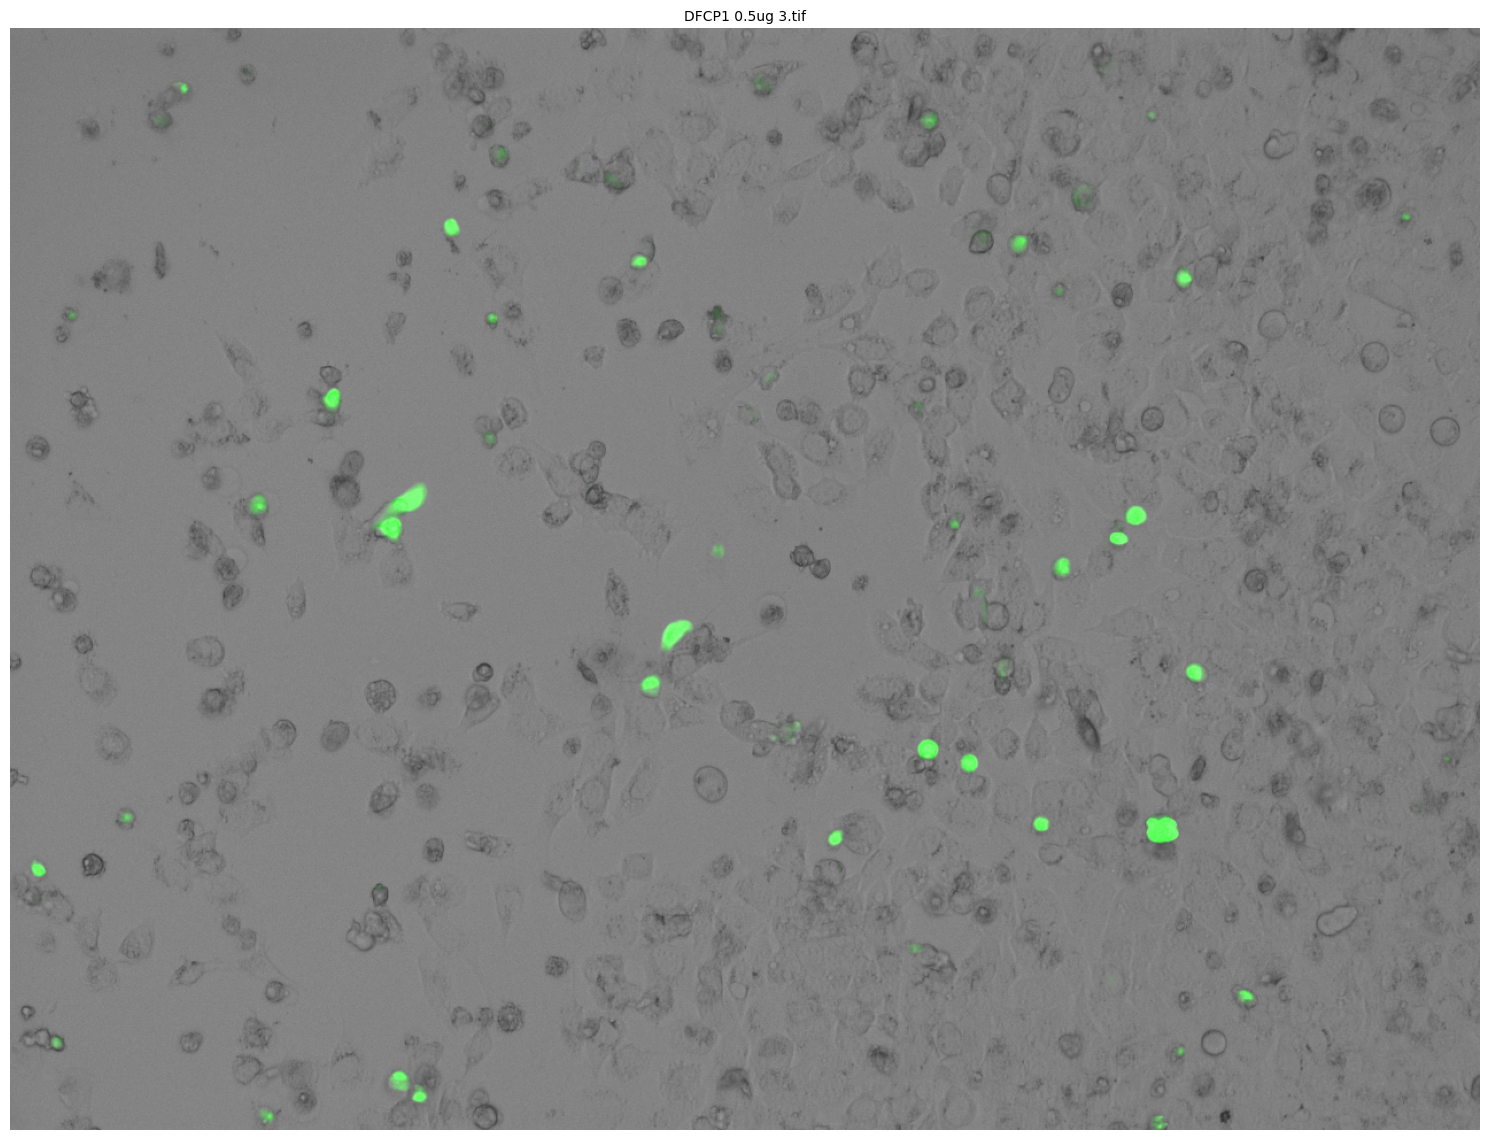

In [44]:
def display_tiff_images(file_paths, figsize=(15, 15)):
    """
    Display one or multiple TIFF images in a grid layout
    
    Parameters:
        file_paths: Single path string or list of path strings
        figsize: Tuple specifying figure size (width, height)
    """
    # Convert single path to list
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    # Calculate grid dimensions
    n_images = len(file_paths)
    if n_images == 1:
        # For single image, create a single subplot
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        try:
            # Read image
            img = tifffile.imread(str(file_paths[0]))
            
            # Convert to 8-bit if necessary
            if img.dtype != np.uint8:
                img = ((img - img.min()) * (255.0 / (img.max() - img.min()))).astype(np.uint8)
            
            # Display image
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add title (filename without path)
            title = os.path.basename(file_paths[0])
            ax.set_title(title, fontsize=10, pad=5)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading image:\n{str(e)}', 
                   ha='center', va='center', color='red',
                   transform=ax.transAxes, wrap=True)
            ax.axis('off')
    
    else:
        # Multiple images: use grid layout
        cols = min(3, n_images)  # Max 3 columns
        rows = (n_images + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.ravel()
        
        # Display each image
        for idx, (ax, file_path) in enumerate(zip(axes, file_paths)):
            try:
                # Read image
                img = tifffile.imread(str(file_path))
                
                # Convert to 8-bit if necessary
                if img.dtype != np.uint8:
                    img = ((img - img.min()) * (255.0 / (img.max() - img.min()))).astype(np.uint8)
                
                # Display image
                ax.imshow(img, cmap='gray')
                ax.axis('off')
                
                # Add title (filename without path)
                title = os.path.basename(file_path)
                ax.set_title(title, fontsize=10, pad=5)
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error loading image:\n{str(e)}', 
                       ha='center', va='center', color='red',
                       transform=ax.transAxes, wrap=True)
                ax.axis('off')
        
        # Hide empty subplots
        for idx in range(len(file_paths), len(axes)):
            axes[idx].axis('off')
    
    plt.tight_layout()
    return fig

# Example usage:
# Single image
print(tif_files[15]) # print the path of the image
display_tiff_images(tif_files[15])

# Multiple images
# display_tiff_images(tif_files[0:5])

In [54]:
import pandas as pd

def process_all_files_to_csv(tif_files, output_csv_path="cell_counts.csv"):
    """
    Process all TIF files and save results to CSV
    
    Parameters:
    tif_files : list of str
        List of TIF file paths
    output_csv_path : str
        Path where the CSV file will be saved
    """
    # Process all files
    print(f"Processing {len(tif_files)} files...")
    results = process_files(tif_files)
    
    # Convert results to DataFrame
    df = pd.DataFrame([
        {
            'Index': idx,
            'File Path': os.path.join(result['directory'], result['filename']),
            'Total Cell Count': result['total_cells'],
            'Green Cell Count': result['green_cells']
        }
        for idx, result in enumerate(results, 1)
    ])
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"\nResults saved to: {output_csv_path}")
    
    # Display summary
    print("\nSummary Statistics:")
    print(f"Total files processed: {len(results)}")
    print(f"Average total cells per image: {df['Total Cell Count'].mean():.2f}")
    print(f"Average green cells per image: {df['Green Cell Count'].mean():.2f}")
    
    return df

# Execute the processing
if tif_files:
    # You can specify a different path for the CSV if needed
    csv_path = "cell_analysis_results.csv"
    
    # Process all files and get the DataFrame
    results_df = process_all_files_to_csv(tif_files, csv_path)
    
    # Display first few rows of the results
    print("\nFirst few rows of the results:")
    print(results_df.head())
else:
    print("No files available to process!")

Processing 130 files...

Processing: DFCP1 1ug 2.tif
From directory: ./trial 2/48h/DFCP1 1ug

Results:
Total cells: 251
Green cells: 15
Green percentage: 5.98%
Visualization saved to: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 2_analyzed.jpg

Processing: DFCP1 1ug 3.tif
From directory: ./trial 2/48h/DFCP1 1ug

Results:
Total cells: 251
Green cells: 15
Green percentage: 5.98%
Visualization saved to: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 3_analyzed.jpg

Processing: DFCP1 1ug 1.tif
From directory: ./trial 2/48h/DFCP1 1ug

Results:
Total cells: 244
Green cells: 17
Green percentage: 6.97%
Visualization saved to: ./trial 2/48h/DFCP1 1ug/DFCP1 1ug 1_analyzed.jpg

Processing: atg13 0.5ug 1.tif
From directory: ./trial 2/48h/atg13 0.5

Results:
Total cells: 75
Green cells: 21
Green percentage: 28.0%
Visualization saved to: ./trial 2/48h/atg13 0.5/atg13 0.5ug 1_analyzed.jpg

Processing: atg13 0.5ug 2.tif
From directory: ./trial 2/48h/atg13 0.5

Results:
Total cells: 114
Green cells: 25
Green percentage: 21.93